<a href="https://colab.research.google.com/github/Laskiri/BookListing/blob/main/mi_e22_session6_NER_FFNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<!-- <img align=center src="https://studyarchitecture.com/wp-content/uploads/mcgill-university-logo-png-transparent-cropped.png"></img> -->
<h2 align=center> Named Entity Recognition (NER) using FFNNs with Keras</h2>

### Step 1 Set up packages

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
np.random.seed(0)
plt.style.use("ggplot")

import tensorflow as tf
print('Tensorflow version:', tf.__version__)
print('GPU detected:', tf.config.list_physical_devices('GPU'))

Tensorflow version: 2.13.0
GPU detected: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Step 2: Load and Explore the NER Dataset

*tagged entities*:

Tag| Explaination
--- | ---
geo | Geographical Entity
org| Organization
per |Person
gpe |Geopolitical Entity
tim |Time indicator
art |Artifact
eve |Event
nat| Natural Phenomenon

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Step 2b: Update the path below

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/ner_dataset.csv", encoding="latin1")

data = data.fillna(method="ffill")
data.head(20)

Sentence #           Word  POS    Tag
0   Sentence: 1      Thousands  NNS      O
1   Sentence: 1             of   IN      O
2   Sentence: 1  demonstrators  NNS      O
3   Sentence: 1           have  VBP      O
4   Sentence: 1        marched  VBN      O
5   Sentence: 1        through   IN      O
6   Sentence: 1         London  NNP  B-geo
7   Sentence: 1             to   TO      O
8   Sentence: 1        protest   VB      O
9   Sentence: 1            the   DT      O
10  Sentence: 1            war   NN      O
11  Sentence: 1             in   IN      O
12  Sentence: 1           Iraq  NNP  B-geo
13  Sentence: 1            and   CC      O
14  Sentence: 1         demand   VB      O
15  Sentence: 1            the   DT      O
16  Sentence: 1     withdrawal   NN      O
17  Sentence: 1             of   IN      O
18  Sentence: 1        British   JJ  B-gpe
19  Sentence: 1         troops  NNS      O

In [ ]:
print("Unique words in corpus:", data['Word'].nunique())
print("Unique tags in corpus:", data['Tag'].nunique())

Unique words in corpus: 35178
Unique tags in corpus: 17


In [ ]:
words = list(set(data["Word"].values))
words.append("ENDPAD")
num_words = len(words)

In [ ]:
tags = list(set(data["Tag"].values))
num_tags = len(tags)

### Steb 2c: Let's have a look at the class balance

In [ ]:
import plotly.express as px

# This first plot shows all classes *except* for the 'O' class
#fig = px.histogram(data[~data.Tag.str.contains("O")], x="Tag",color="Tag")

#TODO: Compare with this plot, which shows *all* classes
fig = px.histogram(data, x="Tag",color="Tag")

fig.show()

### Step 3: Data Manipulation (integrate tokens from same sentence)


In [ ]:
import tqdm
def sentence_integrate(data):
  agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
  return data.groupby('Sentence #').apply(agg_func).tolist()



In [ ]:
sentences=sentence_integrate(data)

In [ ]:
import plotly.express as px

fig = px.histogram(pd.DataFrame([len(s) for s in sentences],columns=['length']),x="length",marginal='box')
fig.show()

In [ ]:
sentences[0]

[('Thousands', 'NNS', 'O'),
 ('of', 'IN', 'O'),
 ('demonstrators', 'NNS', 'O'),
 ('have', 'VBP', 'O'),
 ('marched', 'VBN', 'O'),
 ('through', 'IN', 'O'),
 ('London', 'NNP', 'B-geo'),
 ('to', 'TO', 'O'),
 ('protest', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('war', 'NN', 'O'),
 ('in', 'IN', 'O'),
 ('Iraq', 'NNP', 'B-geo'),
 ('and', 'CC', 'O'),
 ('demand', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('withdrawal', 'NN', 'O'),
 ('of', 'IN', 'O'),
 ('British', 'JJ', 'B-gpe'),
 ('troops', 'NNS', 'O'),
 ('from', 'IN', 'O'),
 ('that', 'DT', 'O'),
 ('country', 'NN', 'O'),
 ('.', '.', 'O')]

### Step 4: Build a vocabulary for words and tags

In [ ]:
word2idx = {w: i + 1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

In [ ]:
tag2idx

{'I-per': 0,
 'B-org': 1,
 'B-geo': 2,
 'O': 3,
 'I-geo': 4,
 'I-art': 5,
 'I-org': 6,
 'B-art': 7,
 'I-tim': 8,
 'B-eve': 9,
 'B-tim': 10,
 'B-nat': 11,
 'I-gpe': 12,
 'B-per': 13,
 'I-eve': 14,
 'B-gpe': 15,
 'I-nat': 16}

### Step 5: Unwrapping to individual words (necessary for the FFNN)

In [ ]:
X = [word2idx[w[0]] for s in sentences for w in s]
y = [tag2idx[w[2]] for s in sentences for w in s]

###Steb 5b: We don't have time to train on everything :')

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, shuffle=False)

cutoff = 10000

x_train = x_train[:cutoff]
y_train = y_train[:cutoff]

### Step 6: Build an FFNN-based model for this dataset

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding

In [ ]:

# define the keras model
model = Sequential()

# Input Layer
model.add(Embedding(len(word2idx), 64) ) # Will be covered in the next lecture! :)

model.add(Dense(16, input_shape=(64,), activation='relu'))

# Hidden Layer(s)
# TODO: Add some more here!
# EXAMPLE:
model.add(Dense(16, activation='relu'))
#model.add(Dense(16, activation='gelu'))

# Output Layer
# TODO: Changing anything here probably won't do much good
model.add(Dense(len(tag2idx), activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          2251456   
                                                                 
 dense (Dense)               (None, None, 16)          1040      
                                                                 
 dense_1 (Dense)             (None, None, 16)          272       
                                                                 
 dense_2 (Dense)             (None, None, 17)          289       
                                                                 
Total params: 2253057 (8.59 MB)
Trainable params: 2253057 (8.59 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


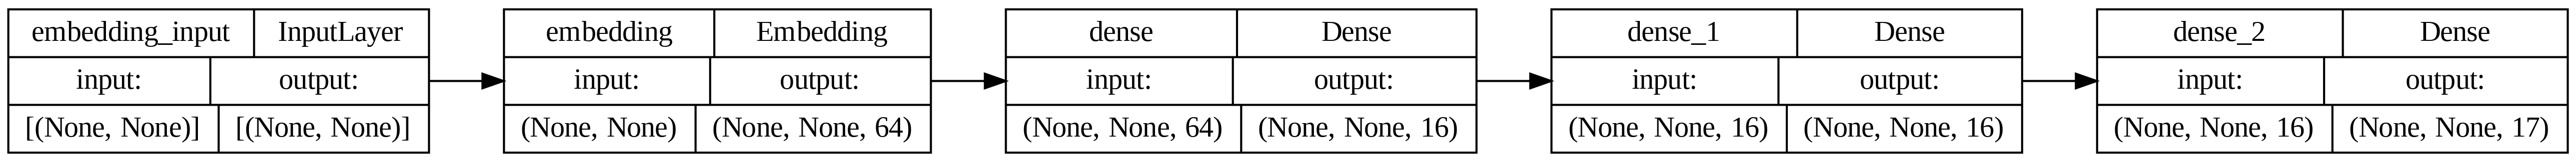

In [ ]:
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=True, show_dtype=False,
    show_layer_names=True, rankdir='LR', expand_nested=True, dpi=300,
)

In [ ]:
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

### Step 7: Train the Model

In [ ]:
!pip install livelossplot

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from livelossplot.tf_keras import PlotLossesCallback

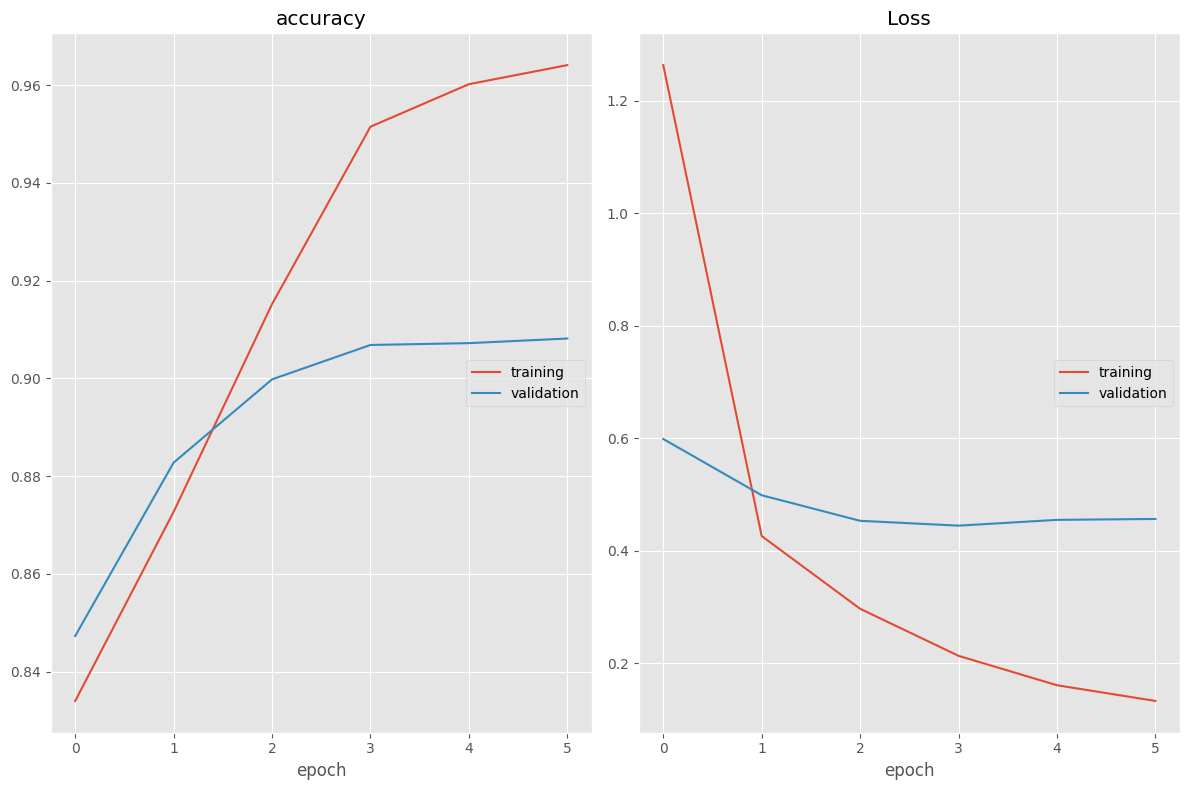

accuracy
	training         	 (min:    0.834, max:    0.964, cur:    0.964)
	validation       	 (min:    0.847, max:    0.908, cur:    0.908)
Loss
	training         	 (min:    0.133, max:    1.263, cur:    0.133)
	validation       	 (min:    0.444, max:    0.598, cur:    0.456)

Epoch 6: val_loss did not improve from 0.44434
313/313 [==============================] - 22s 72ms/step - loss: 0.1326 - accuracy: 0.9641 - val_loss: 0.4562 - val_accuracy: 0.9082
CPU times: user 1min 45s, sys: 8.47 s, total: 1min 54s
Wall time: 3min 10s


In [ ]:
%%time

logdir="log/"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

chkpt = ModelCheckpoint("model_weights.h5", monitor='val_loss',verbose=1, save_best_only=True, save_weights_only=True, mode='min')

#early_stopping = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=1, verbose=0, mode='max', baseline=None, restore_best_weights=False)

#callbacks = [PlotLossesCallback(), chkpt, early_stopping,tensorboard_callback]
callbacks = [PlotLossesCallback(), chkpt, tensorboard_callback]

history = model.fit(
    x=x_train,
    y=y_train,
    validation_data=(x_test,y_test),
    batch_size=32,
    epochs=6,
    callbacks=callbacks,
    verbose=1
)

In [ ]:
model.predict(x_test)

TypeError: ignored

In [ ]:
%load_ext tensorboard

%tensorboard --logdir log

<IPython.core.display.Javascript object>

#### Apply TensorBoard to check the detailed structure and performance

### Step 8: Evaluate the performance of Named Entity Recognition Model

In [ ]:
print("Evaluate on test data")
results = model.evaluate(x_test, y_test, batch_size=128)
print("test loss: {} ".format(results[0]))
print("test accuracy: {} ".format(results[1]))

Evaluate on test data
1639/1639 [==============================] - 7s 4ms/step - loss: 0.4562 - accuracy: 0.9082
test loss: 0.45623230934143066 
test accuracy: 0.9081563353538513 


In [ ]:
i = np.random.randint(0, 2000)
print("This is sentence:",i)
p = model.predict(np.array([x_test[i:i+50]]))
p = np.argmax(p, axis=-1)
print(i, p)

print("{:15}{:5}\t {}\n".format("Word", "True", "Pred"))
print("-" *30)
for w, true, pred in zip(x_test[i:i+50], y_test[i:i+50], p[0]):
    print("{:15}{}\t{}".format(words[w-1], tags[true], tags[pred]))

This is sentence: 684
1/1 [==============================] - 0s 243ms/step
684 [[ 3  3  2  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
   3  3  3  3  3  3  3  3  3  3  3  3 15  3  3  3  3  3  3  3  3  3  2  3
   3  3]]
Word           True 	 Pred

------------------------------
Zebari         I-per	O
said           O	O
Baghdad        B-geo	B-geo
looks          O	O
forward        O	O
to             O	O
resolving      O	O
several        O	O
issues         O	O
between        O	O
the            O	O
two            O	O
countries      O	O
,              O	O
including      O	O
the            O	O
fate           O	O
of             O	O
missing        O	O
people         O	O
and            O	O
the            O	O
exchange       O	O
of             O	O
remains        O	O
of             O	O
soldiers       O	O
from           O	O
their          O	O
eight-year     B-tim	O
war            O	O
that           O	O
ended          O	O
in             O	O
1988           B-tim	O
.              O	O


In [ ]:
from sklearn.metrics import f1_score

out = model.predict(x_test)

preds = np.argmax(out, axis=1)
print("F1 score: ", f1_score(y_test, preds, average='macro'))

TypeError: ignored